In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import json
import h5py
from utils import img_data_2_mini_batch, imgs2batch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

%matplotlib inline
%reload_ext autoreload

In [2]:
base_f = 'cocoqa_data_prepro_'
base_n = '93'
base_fn = base_f + base_n




transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


In [3]:
val_data_h5 = h5py.File(base_fn+'.h5', 'r')

In [4]:

val_data_json = json.load(open(base_fn+'.json', 'r'))
# pad fix
itow = val_data_json['ix_to_word']

wtoi = {iv: ik for ik,iv in itow.items()}
old_pad = wtoi['<pad>']
wtoi['<pad_fix>'] = old_pad
wtoi['<pad>'] = '0'
itow[old_pad] = '<pad_fix>'
itow['0'] = '<pad>'

# print wtoi['<pad>']
# print itow['0']
# print wtoi['<pad_fix>']

assert(wtoi['<pad>'] == '0')
assert(itow['0'] == '<pad>')


# print val_data_json.keys()
# print val_data_h5.keys()

In [14]:
itoa = val_data_json['ix_to_ans']
# print len(itoa)
# print itoa['38']
# print itoa
unique_img_val = val_data_json['unique_img_val']
ques_val = val_data_h5['ques_val'][:]
ans_val = val_data_h5['ans_val'][:]
question_id_val = val_data_h5['question_id_val'][:]
img_pos_val = val_data_h5['img_pos_val'][:]
images = np.array(imgs2batch(unique_img_val, img_pos_val, transform=transform))
ques_val = np.array(ques_val)
ans_val = np.array(ans_val).reshape((-1, 1))

# print images.shape

images = torch.from_numpy(images)
ques_val = torch.from_numpy(ques_val)
ans_val = torch.from_numpy(ans_val)

# print images.size()
# print ques_val.size()
# print ans_val.size()
# print(ans_val.shape)


In [15]:
# for i in range(ques_val.size(1)):
#     print ' '.join(filter(lambda kx: kx!='<pad>',(map(lambda wr: itow[str(wr)], ques_val[i].detach().numpy().tolist()))))
#     print ' '.join(map(lambda wr: itoa[str(wr)], ans_val[i].detach().numpy().tolist()))


In [16]:
ques_ans_val = torch.cat((ques_val, ans_val), dim=1)
BATCH_SIZE = 20
dataset=Data.TensorDataset(images, ques_ans_val)
# img, abc = dataset[0]
# print img.shape
# plt.figure()
# plt.imshow(img.reshape((224,2,3)))

train_loader = Data.DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )


In [17]:
from naive import Enc, Dec
device = torch.device('cuda')
embed_size = 128
hidden_size = 128
ques_vocab_size = len(itow)
ans_vocab_size = len(itoa)+1
num_layers = 1

# print 'embed',embed_size,'hidden',hidden_size,'ques_vocab',ques_vocab_size, 'ans_vocab',ans_vocab_size
encoder = Enc(embed_size).to(device)
decoder = Dec(embed_size, hidden_size, ques_vocab_size, ans_vocab_size, num_layers).cuda()
# encoder.double()


In [36]:
# optimizer and loss
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params,lr=0.01)
encoder.train()
decoder.train()
# start your train
lossList = []
accList = []
for epoch in range(1):
    for i, (images, img_ans_val) in enumerate(train_loader):
        ques, ans = torch.split(img_ans_val, 26,dim=1)
        # images of shape [batch, 3, 256, 256]
        # ques of shape [batch, 26]
        # ans of shape [batch, 1]

        lengths = []
        for qix in ques:
            for iy in range(len(qix)):
                if (qix[iy]==0):
                    lengths.append(iy)
                    break;
        tups = []
        for ix in range(ques.size(0)):
            row = ques[ix,:]
            length = lengths[ix]
            image_i = images[ix,:]
            ans_i = ans[ix,:]
            tup = (row, length, image_i, ans_i)
            tups.append(tup)

        sorted_tuples = sorted(tups, key=lambda tup: tup[1], reverse=True)
        questions = torch.stack(list(map(lambda tup: tup[0], sorted_tuples)))
        images = torch.stack(list(map(lambda tup: tup[2], sorted_tuples)))
        answers = torch.stack(list(map(lambda tup: tup[3], sorted_tuples)))
        lengths = list(map(lambda tup: tup[1], sorted_tuples))
        
#         print 'images', images.size()
#         print 'img_ans_val', img_ans_val.size()
#         print 'questions', questions.size()
#         print 'answers', answers.size()
#         print 'lengths', lengths
    
        images = images.to(device)
        questions = questions.to(device).long()
        features = encoder(images).cuda()
#         print '[OUT] features',features.size()
        output = decoder(features, questions, lengths).cuda()
        answers = answers.reshape((-1)).long().cuda()
#         print '[OUT] output ', output.size()
#         print '[OUT] answers ', answers.size()
        loss = F.nll_loss(output, answers)

        # copy here
        lossList.append(loss.item())
        
        _, pred = torch.max(output, dim=1)
        
        correct = pred.eq(answers.long().view_as(pred)).sum()
        acc = float(correct) / float(BATCH_SIZE)
        
        accList.append(acc)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('epoch',epoch,'#', i, 'loss:', loss.item(), 'acc:', acc, 'correct:', correct)
        
        
        
        
        
# test
encoder.eval()
decoder.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
        
        

epoch 0 # 0 loss: 0.7504260540008545 acc: 0.75 correct: tensor(15, device='cuda:0')
epoch 0 # 1 loss: 0.3869618773460388 acc: 0.85 correct: tensor(17, device='cuda:0')
epoch 0 # 2 loss: 0.2797730565071106 acc: 0.95 correct: tensor(19, device='cuda:0')
epoch 0 # 3 loss: 0.43175363540649414 acc: 0.8 correct: tensor(16, device='cuda:0')
epoch 0 # 4 loss: 0.3425388038158417 acc: 0.6 correct: tensor(12, device='cuda:0')


Enc(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_siz

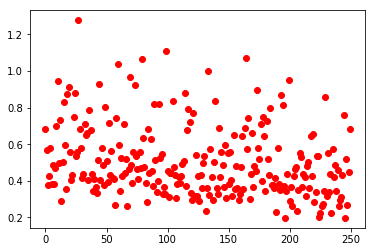

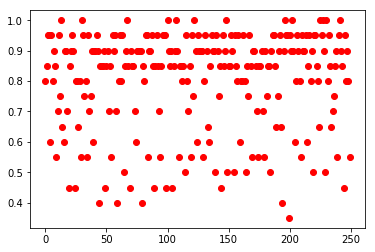

In [29]:
plt.figure()
plt.plot(range(len(lossList)), lossList, 'ro')
plt.show()

plt.figure()
plt.plot(range(len(accList)), accList, 'ro')
plt.show()